# eQTL

This tutorial illustrates the use of limix to analyse expression datasets.
We consider gene expression levels from a yeast genetics
study with freely available data.
This data set span 109 individuals with 2,956 marker SNPs and expression
levels for 5,493 in glucose and ethanol growth media respectively.

## Importing limix

In [1]:
import limix

## Shorter output

In [2]:
import pandas as pd
pd.set_option("display.float_format", "{:8.5g}".format)

## Downloading data

We are going to use a HDF5 file containg phenotype and genotyped data from
a remote repository.
Limix provides some handy utilities to perform common command line tasks,
like as downloading and extracting files.
However, feel free to use whatever method you prefer.

In [3]:
url = "http://rest.s3for.me/limix/smith08.hdf5.bz2"
limix.sh.download(url, verbose=False, force=True)
print(limix.sh.filehash("smith08.hdf5.bz2"))

aecd5ebabd13ed2e38419c11d116e8d582077212efb37871a50c3a08fadb2ee1


In [4]:
limix.sh.extract("smith08.hdf5.bz2", verbose=False)
limix.io.hdf5.see("smith08.hdf5")

/
  +--genotype
  |  +--col_header
  |  |  +--chrom [int64, (2956,)]
  |  |  +--pos [int64, (2956,)]
  |  |  +--pos_cum [int64, (2956,)]
  |  +--matrix [float64, (109, 2956)]
  |  +--row_header
  |     +--sample_ID [int64, (109,)]
  +--phenotype
     +--col_header
     |  +--environment [float64, (10986,)]
     |  +--gene_ID [|S100, (10986,)]
     |  +--gene_chrom [|S100, (10986,)]
     |  +--gene_end [int64, (10986,)]
     |  +--gene_start [int64, (10986,)]
     |  +--gene_strand [|S100, (10986,)]
     |  +--phenotype_ID [|S100, (10986,)]
     +--matrix [float64, (109, 10986)]
     +--row_header
        +--sample_ID [int64, (109,)]


In [5]:
data = limix.io.hdf5.read_limix("smith08.hdf5")
Y = data['phenotype']
G = data['genotype']
print(Y)

<xarray.DataArray 'phenotype' (sample: 109, outcome: 10986)>
array([[-0.037339, -0.078165,  0.042936, ...,  0.095596, -0.132385, -0.274954],
       [-0.301376,  0.066055,  0.338624, ..., -0.142661, -0.238349,  0.732752],
       [ 0.002661,  0.121835, -0.137064, ..., -0.144404,  0.257615,  0.015046],
       ...,
       [-0.287339,  0.351835,  0.072936, ...,  0.097339, -0.038349,  0.162752],
       [-0.577339,  0.011835, -0.007064, ...,  0.135596,  0.107615,  0.245046],
       [-0.277339,  0.061835,  0.132936, ...,  0.015596, -0.142385, -0.124954]])
Coordinates:
  * sample        (sample) int64 0 1 2 3 4 5 6 7 ... 102 103 104 105 106 107 108
    environment   (outcome) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    gene_ID       (outcome) object 'YOL161C' 'YJR107W' ... 'YLR118C' 'YBR242W'
    gene_chrom    (outcome) object '15' '10' '16' '7' '4' ... '3' '10' '12' '2'
    gene_end      (outcome) int64 11548 628319 32803 ... 315049 384726 705381
    gene_start    (outcome) int64 1

## Selecting gene YBR115C under the glucose condition

Query for a specific phenotype, select the phenotype itself, and plot it.
The glucose condition is given by the environment ``0``.

In [6]:
y = Y[:, (Y.gene_ID == "YBR115C") & (Y.environment==0)]
y = y.stack(z=('sample', 'outcome')).reset_index('z')
y = y.rename(z="sample")
limix.plot.normal(y)
limix.plot.show()

<Figure size 640x480 with 1 Axes>

## Genetic relatedness matrix

The genetic relatedness will be determined by the inner-product of SNP
readings between individuals, and the result will be visualised via heatmap.

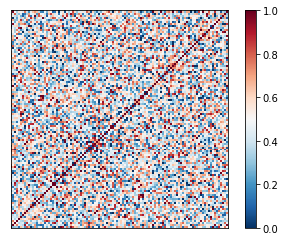

In [7]:
K = limix.stats.linear_kinship(G.values, verbose=False)
limix.plot.kinship(K)
limix.plot.show()

## Univariate association test with linear mixed model

You have the option to either pass a raw array of samples-by-candidates for
the association scan or pass a tabular structure naming those candidates.
We recommend the second option as it will help maintain the association between
the results and the corresponding candidates.

The naming of those candidates is defined here by concatenating the chromossome
name and base-pair position.
However, it is often the case that SNP IDs are provided along with the
data, which can naturally be used for naming those candidates.

In [8]:
from pandas import DataFrame
import numpy as np

print(G)

<xarray.DataArray 'genotype' (sample: 109, candidate: 2956)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 7 ... 101 102 103 104 105 106 107 108
    chrom    (candidate) int64 1 1 1 1 1 1 1 1 1 ... 16 16 16 16 16 16 16 16 16
    pos      (candidate) int64 483 484 3220 3223 ... 927506 932310 932535 932538
    pos_cum  (candidate) int64 483 484 3220 3223 ... 12055570 12055795 12055798
Dimensions without coordinates: candidate


As you can see, we now have a pandas data frame ``G`` that keeps the candidate
identifications together with the actual allele read.
This data frame can be readily used to perform association scan.

In [9]:
print(y)

<xarray.DataArray 'phenotype' (sample: 109)>
array([ 3.504479,  1.914585,  3.434479, -2.075521,  1.654585,  3.304479,
        2.044585, -4.125415,  2.024585,  0.732574, -0.80732 ,  3.464479,
       -2.385521,  3.644479, -4.785415, -2.895521,  0.732574, -3.155521,
       -0.80732 , -0.80732 ,  0.732574, -2.695521, -2.835521, -4.635415,
        0.732574,  1.804585, -0.80732 ,  1.964585,  2.304585,  2.484585,
        2.424585,  2.534585,  3.254479, -0.80732 , -4.555415, -1.815521,
        1.934585, -2.065521,  1.754585,  2.014585,  0.732574, -2.835521,
       -2.715521, -3.115521,  1.854585,  3.544479, -0.80732 ,  2.594585,
        3.574479, -3.175521,  0.732574, -2.395521,  1.824585,  2.134585,
       -0.80732 , -2.775521, -2.255521, -0.80732 ,  3.544479,  1.894585,
        3.364479, -2.775521, -0.80732 ,  2.034585, -4.695415, -0.80732 ,
        1.864585,  2.174585, -3.815521,  1.674585, -2.725521, -2.685521,
       -1.345521, -2.405521, -4.035415, -0.80732 , -0.80732 , -2.255521,
      

In [10]:
print(G)

<xarray.DataArray 'genotype' (sample: 109, candidate: 2956)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 7 ... 101 102 103 104 105 106 107 108
    chrom    (candidate) int64 1 1 1 1 1 1 1 1 1 ... 16 16 16 16 16 16 16 16 16
    pos      (candidate) int64 483 484 3220 3223 ... 927506 932310 932535 932538
    pos_cum  (candidate) int64 483 484 3220 3223 ... 12055570 12055795 12055798
Dimensions without coordinates: candidate


In [11]:
qtl = limix.qtl.st_scan(G, y, 'normal', K, verbose=False)
print(qtl)

Variants
--------
       effsizes  effsizes_se    pvalues
count      2956         2956       2956
mean    0.12974      0.58919    0.56056
std     0.55063      0.11409    0.27785
min     -1.2671      0.41405 2.5833e-20
25%    -0.23013      0.51869    0.33392
50%    0.071479      0.56313    0.56104
75%     0.44985      0.61117     0.8007
max      4.1984      0.96306    0.99967

Covariate effect sizes for H0
-----------------------------
  offset
0.012073


Inspecting the p-values and effect-sizes are now easier because candidate
names are kept together with their corresponding statistics.

In [12]:
pv = qtl.variant_pvalues
pv = pv.sortby(pv).to_dataframe()
pv["-log10(pv)"] = -np.log10(pv["pv"])
print(pv.head())

           chrom     pos  pos_cum         pv  -log10(pv)
candidate                                               
0              2  477206   707424 2.5833e-20      19.588
1              2  479161   709379 1.2502e-13      12.903
2              2  479164   709382 1.2502e-13      12.903
3              2  479166   709384 1.2502e-13      12.903
4              2  480009   710227 9.0861e-13      12.042


In [13]:
print(qtl.variant_effsizes.sel(candidate=pv.index).to_dataframe().head())

           chrom   pos  pos_cum  effsizes
candidate                                
0              1   483      483   0.58018
1              1   484      484   0.26697
2              1  3220     3220   0.46157
3              1  3223     3223   0.46157
4              1  3232     3232   0.46157


A Manhattan plot can help understand the result.

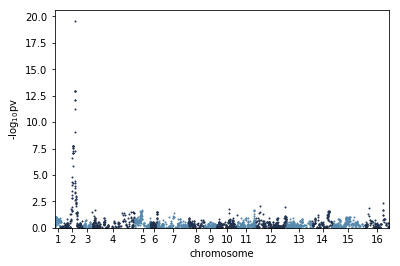

In [14]:
limix.plot.manhattan(qtl.variant_pvalues)
limix.plot.show()

We then remove the temporary files.

In [15]:
limix.sh.remove("smith08.hdf5.bz2")
limix.sh.remove("smith08.hdf5")